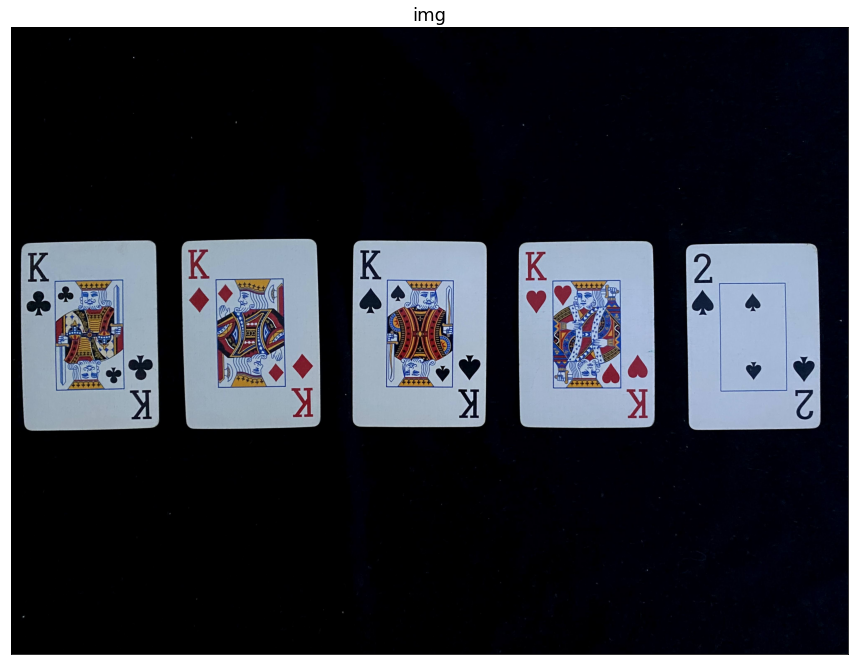

The card is: King of clubs


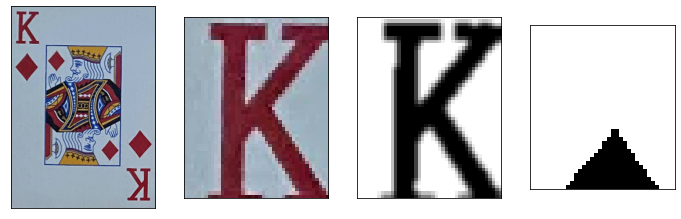

The card is: King of clubs


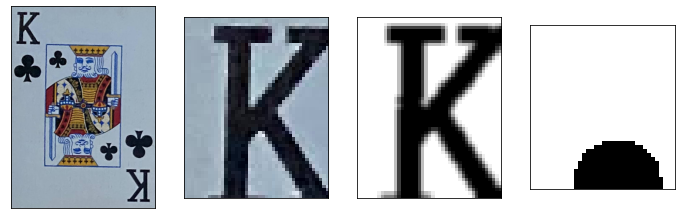

The card is: King of diamonds


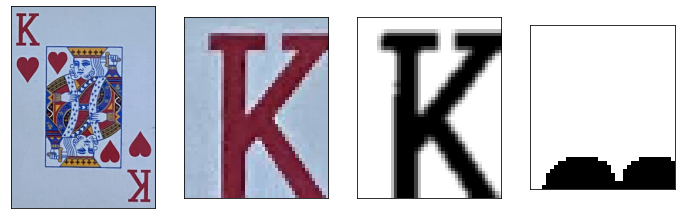

The card is: King of hearts


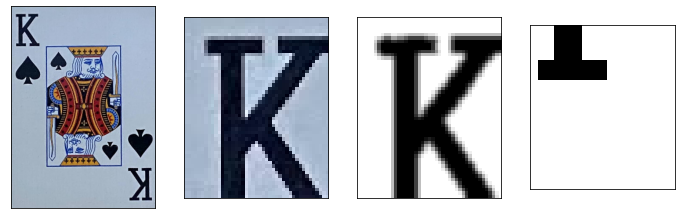

The card is: 9 of hearts


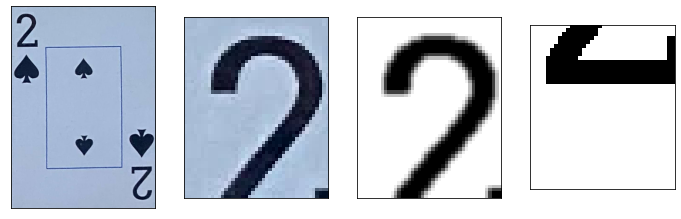

Calculating Hand using with:  ['King', 'King', 'King', 'King', '9'] ['club', 'club', 'diamond', 'heart', 'heart']
4 of a kind


In [1]:
#Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as image
import easygui
import pytesseract

plt.rcParams['figure.figsize'] = [15,20]#set the plot size
plt.rc('font', size=15)

#Taking in arrays of card types and symbols and checking what type of poker hand it is
def GetHandType(cardType,cardSymbols):
    isSequential = True#for checking if all the cards come up in a sequence of 5
    print("Calculating Hand using with: ",cardType,cardSymbols)
    
    #Need to make an array of what position that card is based on the value of cards
    allCardIndexes = []#For holding the positions of the the cards in order of value in a deck
    i = 0
    while i < len(cardType):#for each card, add to array
        if(allPlayingCardTypes.__contains__(cardType[i])):#Error checking to make sure it doesnt add non cards
            allCardIndexes.append(allPlayingCardTypes.index(cardType[i]))
        else:
            print("cant add to numbers list")
            isSequential = False#Cant be sequential if it has incorrect input
        i+=1
    allCardIndexes.sort()#This sorts all the position values of the card list 
    
    j = 0
    while j < len(allCardIndexes)-1:
        if(allCardIndexes[j+1] == allCardIndexes[j]+1):#If the next allPlayingCardTypes position index value is one higher than the last
            print(allCardIndexes[j+1],"=",allCardIndexes[j]+1, "  full list: ",allCardIndexes)
        else:
            isSequential = False#The numbers arent sequential
            break#stop while loop
        j+=1
            
            
    handResult = ""
    #This is done in the order of highest scoring cards so it will return the best hand first, etc returns two pairs not one pair
    if(cardSymbols.count(cardSymbols[0])>=5 and isSequential):
        if(cardType.__contains__("Ace") and cardType.__contains__("King") and cardType.__contains__("Queen") and cardType.__contains__("Jack") and cardType.__contains__("10")):
            handResult = "Royal Flush"#is a straight flush but from 10 to A
        else:
            handResult = "Straight Flush"
    elif(cardType.count(cardType[0])>=4 or cardType.count(cardType[1])>=4):#Check 2 numbers because one of the cards can be random
        handResult = "4 of a kind"
    elif(cardType.count(cardType[0])>=3 or cardType.count(cardType[1])>=3 or cardType.count(cardType[2])>=3):
        #A set of 3, either the other set has 2 or not meaning its fullhouse or three of a kind
        if(cardType.count(cardType[0])==2 or cardType.count(cardType[1])==2 or cardType.count(cardType[2])==2 or cardType.count(cardType[3])==2):
            handResult = "FullHouse"
        else:#This is okay to set ahead of flush or straight even though its worth less because they cant be achieved if this 3 cards are the same
            handResult = "3 of a kind"
    elif(cardSymbols.count(cardSymbols[0])>=5):
        handResult = "Flush"
    elif(isSequential):
        handResult = "Straight"
    elif(cardType.count(cardType[0])>=2 or cardType.count(cardType[1])>=2 or cardType.count(cardType[2])>=2 or cardType.count(cardType[3])>=2 or cardType.count(cardType[4])>=2):
        #Theres atleast one pair
        cardsWithMatch = 0
        i = 0
        while i < len(cardType):
            if cardType.count(cardType[i])>=2:
                cardsWithMatch += 1
            i+=1
        if(cardsWithMatch == 4):#If not 3 of a kind but 4 cards still match then there must be 2 pairs
            handResult = "Two pairs"
        else:#If more than 2 matching cards but not 4 then just one pair
            handResult = "One pair"
        print("t cards with matches: ",cardsWithMatch)
    else:#No special hands means no pairs / nothing
        handResult = "No pairs"
        
    print(handResult)
    
        
    if(cardType[0]==cardType[1] and cardType[1]==cardType[2] and cardType[2]==cardType[3] and cardType[3]==cardType[4]):
        print("Four of a kind")
        
def warpPerspective(contour):
    largestContour = contour
    width, height = 250, 350
    pts2 = np.float32([[0,0],[width,0], [width,height],[0, height]])
    pts1 = np.float32([[0,0],[0,0],[0,0],[0,0]])
    for cnt in largestContour :
        
        approx = cv2.approxPolyDP(largestContour, 0.009 * cv2.arcLength(largestContour, True), True) 
        l = 0
        
        # Used to flatted the array containing 
        # the co-ordinates of the vertices. 
        n = approx.ravel()  
        a = 0
  
        for j in n : 
            if(a % 2 == 0):
                r = 0
                x = n[a] 
                y = n[a + 1] 
                pts1[l][r] = x
                pts1[l][r + 1] = y
                l = l + 1  
            a = a + 1
            
    sorted_pts = np.zeros((4, 2), dtype="float32")
    add = np.sum(pts1, axis=1)
    diff = np.diff(pts1, axis=1)
    
    sorted_pts[0] = pts1[np.argmin(add)]
    sorted_pts[2] = pts1[np.argmax(add)]

    sorted_pts[1] = pts1[np.argmin(diff)]
    sorted_pts[3] = pts1[np.argmax(diff)]
    
    matrix = cv2.getPerspectiveTransform(sorted_pts,pts2)
    imgoutput = cv2.warpPerspective(inputImg,matrix,(width,height)) #output of cropped image
    #getLettersandSymbols(imgoutput)
    return imgoutput    

#Use input image of the LEtter int he top left to return the card type
def GetLetter(croppedLetter,fig):
    gCroppedLetter = cv2.cvtColor(croppedLetter, cv2.COLOR_BGR2GRAY)
    #Gets a threshold
    thresh = cv2.threshold(gCroppedLetter, 130, 255, cv2.THRESH_BINARY_INV)[1]
    #Blurs it with threshold
    imBlur = cv2.GaussianBlur(thresh, (3,3), 0)
    imBlur = 255 - imBlur#Invert

    #convert to text from section of image
    textFromImage = pytesseract.image_to_string(imBlur, lang='eng',config='--psm 6')
    
    #Might have picked up some corners of images etc or included spaces so get the first individual char
    if(len(textFromImage) < 2):
        singleChar = textFromImage
    else:
        singleChar = textFromImage[0]
        #print(len(textFromImage),"characters detected: "+textFromImage+"    using char:"+singleChar)
        
    cardType = ""
    #Special cards have a name so return that, or some characters are weird with this card font so it recognises other letters so return most likely one
    if(singleChar == "K" or singleChar == "k"):
        cardType = "King"
    elif(singleChar == "Q"):
        cardType = "Queen"
    elif(singleChar == "J" or singleChar == "j"):
        cardType = "Jack"
    elif(singleChar == "A"):
        cardType = "Ace"
    elif(singleChar == "1" or singleChar == "0" or singleChar == "i"):
        cardType = "10"
    elif(singleChar == "%"):
        cardType = "3"
    else:#is number
        cardType = singleChar
           
    if not(allPlayingCardTypes.__contains__(cardType)):
        print("Error detecting card")
        
    #Add to plot for displaying
    p1 = fig.add_subplot(2, 5, 3), plt.xticks([]),plt.yticks([])
    imgplot = plt.imshow(imBlur, cmap='gray')
    
    return cardType

#Use the cropped image of the symbol to return the suit
def suitComparison(club, diamond, heart, spade, inputTestImage,fig):
    # Variables for comparison
    best_rank_match_diff = 1000000000
    match = "none"
    
    # Performs comparison with heart.
    height, width, _ = heart.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, heart)
    rank_diff = int(np.sum(diff_img)/255)               
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "heart"


    # Performs comparison with spade.
    height, width, _ = spade.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, spade)
    rank_diff = int(np.sum(diff_img)/255)           
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "spade"


    # Performs comparison with club.
    height, width, _ = club.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, club)
    rank_diff = int(np.sum(diff_img)/255)             
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "club"


    # Performs comparison with diamond.
    height, width, _ = diamond.shape
    dim = (width, height)
    testImage = cv2.resize(inputTestImage, dim)

    diff_img = cv2.absdiff(testImage, diamond)
    rank_diff = int(np.sum(diff_img)/255)      
    if rank_diff < best_rank_match_diff:
        best_rank_match_diff = rank_diff
        match = "diamond"


    p1 = fig.add_subplot(2, 5, 4), plt.xticks([]),plt.yticks([])
    imgplot = plt.imshow(inputTestImage, cmap='gray')
    
    # Prints the match with the lowest absdiff
    return match

#Use the input image to 
def readCards(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    G = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img, cmap='gray'), plt.xticks([]),plt.yticks([])
    plt.title('img')
    plt.show()
    
    T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
    C,_ = cv2.findContours(B, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    C = sorted(C, key=cv2.contourArea, reverse=True)
    
    # Reading in suit templates #Note: moved from inside loop
    club = cv2.imread("club.jpg")
    diamond = cv2.imread("diamond.jpg")
    heart = cv2.imread("heart.jpg")
    spade = cv2.imread("spade.jpg")
    
    cardLetters = [""]*5
    cardSymbols = [""]*5
    
    i = 0
    while i < 5:
        fig = plt.figure()#make a figure to show things on

        largestContour = C[i]
        warpedImg = warpPerspective(largestContour)

        #Crop image to just the card
        H,W,Channels = warpedImg.shape

        cropped_letter = warpedImg[int(H * 0.026):int(H * 0.18), int(W * 0.01):int(W * 0.18)]
        cropped_symbol = warpedImg[int(H * 0.165):int(H * 0.28), int(W * 0.03):int(W * 0.175)]
        
        G = cv2.cvtColor(cropped_symbol, cv2.COLOR_BGR2GRAY)
        T, B = cv2.threshold(G, thresh = 120, maxval = 255, type = cv2.THRESH_BINARY)
        inverse = cv2.bitwise_not(B)
        sContour,_ = cv2.findContours(inverse, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
        sC = sorted(sContour, key=cv2.contourArea, reverse=True)

        cropped = cropped_symbol
        croppedH, croppedW, croppedChannels = cropped.shape 
        cropped_symbol = np.zeros([croppedH,croppedW,3],dtype=np.uint8)
        cropped_symbol.fill(255)
        cv2.fillPoly(cropped_symbol, pts =[(sC[0])], color=(0,0,0))
        #cropped_symbol =  cv2.GaussianBlur(cropped_symbol, (3,3), 0)
        
        #if i == 0:
        #    cv2.imwrite("spade.jpg", cropped_symbol)

        #Get cradletter from getletter method
        cardLetter = GetLetter(cropped_letter,fig )

        #Get suit from the suitComparison method
        bestMatch = suitComparison(club, diamond, heart, spade, cropped_symbol,fig)
        print("The card is: "+cardLetter+" of "+bestMatch+"s")
        
        cardLetters[i] = cardLetter
        cardSymbols[i] = bestMatch
        
        warpedImg = cv2.cvtColor(warpedImg, cv2.COLOR_BGR2RGB)
        cropped_letter = cv2.cvtColor(cropped_letter, cv2.COLOR_BGR2RGB)

        p1 = fig.add_subplot(2, 5, 1), plt.xticks([]),plt.yticks([])
        imgplot = plt.imshow(warpedImg, cmap='gray')
        p1 = fig.add_subplot(2, 5, 2), plt.xticks([]),plt.yticks([])
        imgplot = plt.imshow(cropped_letter, cmap='gray')
        plt.show()

        i = i + 1
        
    GetHandType(cardLetters,cardSymbols)
     
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
allPlayingCardTypes = ['Ace','2','3','4','5','6','7','8','9','10','Jack','Queen','King']

f = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])#open user file select
inputImg = cv2.imread(f)#set a file to work with
readCards(inputImg)
        
#while True:
    #try:
        #c = cv2.waitKey(1)
        #if c == 32:#IF keycode space
        #    break
        #f = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])#open user file select
        #inputImg = cv2.imread(f)#set a file to work with
        #readCards(inputImg)
        #break
    #except:
        #print("Error using selected file")
        #break
    
#inputImg = cv2.imread("4OfAKind.png")


